In [47]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rutwika@2004',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/HP/Downloads/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
pip install mysql-connector-python 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="Rutwika@2004",
                           database="ecommerce")

cur=db.cursor()

List all unique cities where customres are located

In [11]:
query = """ Select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

Count the number of orders placed in 2017

In [17]:
query = """ Select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
data[0][0]

45101

Find the total sells per category

In [46]:
query = """ Select products.product_category category, sum(payments.payment_value) sales from products join order_items on products.product_id=order_items.product_id
join payments on order_items.order_id=payments.order_id group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["category","sales"])
df

,category,sales
0,perfumery,1.013477e+06
1,Furniture Decoration,2.860353e+06
2,telephony,9.737641e+05
3,bed table bath,3.425107e+06
4,automotive,1.704589e+06
...,...,...
69,cds music dvds,2.398860e+03
70,La Cuisine,5.827060e+03
71,Fashion Children's Clothing,1.571340e+03
72,PC Gamer,4.348860e+03


#Calculate the percentage of orders that were paid in installments

In [6]:
query = """ Select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('99.9981'),)]

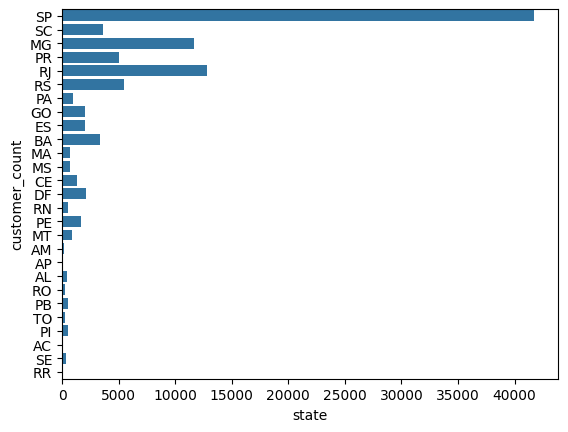

In [14]:
query = """ Select count(customer_id),customer_state from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
sns.barplot(x="state",y="customer_count",data=df)
plt.show()

 Calculate number if orders per month in 2018

In [16]:
 query = """ Select month(order_purchase_timestamp) month, count(order_id) from orders where year(order_purchase_timestamp)=2018 group by month """
cur.execute(query)
data=cur.fetchall()
data

[(7, 6292),
 (8, 6512),
 (2, 6728),
 (6, 6167),
 (3, 7211),
 (1, 7269),
 (5, 6873),
 (4, 6939),
 (9, 16),
 (10, 4)]

Find the average number of products per order, grouped by customers city

In [21]:
query = """ with count_per_order as (Select orders.order_id, orders.customer_id, count(order_items.order_id) as oc from orders join order_items where orders.order_id=order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc),2) from customers join count_per_order where customers.customer_id=count_per_order.customer_id group by customers.customer_city"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1
0,treze tilias,1.27
1,indaial,1.12
2,sao jose dos campos,1.14
3,sao paulo,1.16
4,porto alegre,1.17


Calculate the percentage of total revenue contributed by each product catagory

In [ ]:
query = """Select products.product_category category, sum(payments.payment_value) sales from products join order_items on products.product_id=order_items.product_id
join payments on order_items.order_id=payments.order_id group by category"""
cur.execute(query)
data=cur.fetchall()
data

Identify the correlation between the product price and the number of times a product has been purchased

In [24]:
query = """Select products.product_category category, count(order_items.product_id), avg(order_items.price) from products join order_items on products.product_id= order_items.product_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Order Count","Price"])
df

,Category,Order Count,Price
0,HEALTH BEAUTY,9670,130.163531
1,sport leisure,8641,114.344285
2,Cool Stuff,3796,167.357969
3,computer accessories,7827,116.513903
4,Watches present,5991,201.135984
...,...,...,...
69,flowers,33,33.637576
70,Kitchen portable and food coach,15,264.568666
71,CITTE AND UPHACK FURNITURE,38,114.949473
72,House Comfort 2,30,25.342333


In [26]:
import numpy as np
a1=df["Order Count"]
a2=df["Price"]
np.corrcoef([a1,a2])

array([[ 1.        , -0.10631552],
       [-0.10631552,  1.        ]])

Calculate the revenue generated by each seller and rank them by routine

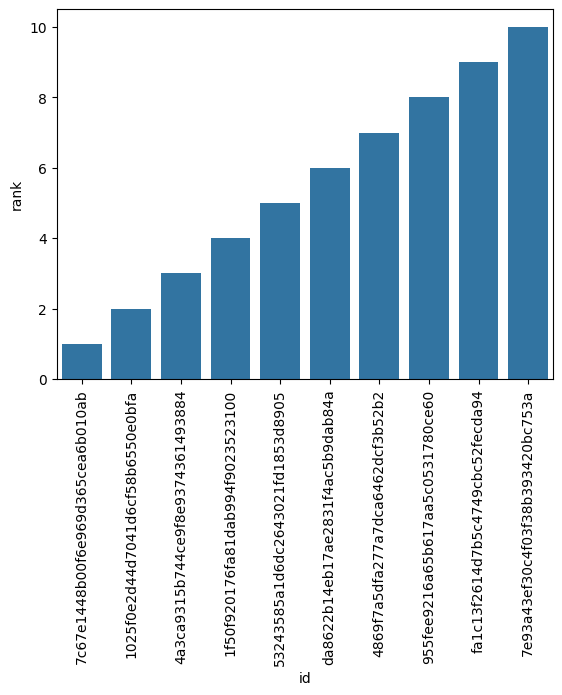

In [45]:
query = """Select *, rank() over(order by revenue desc) as a from
(Select order_items.seller_id, sum(payments.payment_value) revenue from order_items join payments on order_items.order_id=payments.order_id
group by order_items.seller_id) as b"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data, columns=["id","revenue","rank"])
df=df.head(10)
sns.barplot(x="id", y="rank", data=df)
plt.xticks(rotation=90)
plt.show()

Calculate the moving average of order values for each customer over their order history

In [6]:
query = """Select *, avg(payment) over(partition by orders.customer_id order by order_purchase_timestamp rows between 2
preceding and current row) as a from
(Select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment from orders join payments on orders.order_id=payments.order_id) as b"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998


Calculate the cumulative sales per month of each year

In [8]:
query = """Select *, sum(payment) over(order by year, month) as a from
(Select year(orders.order_purchase_timestamp) as year, month(orders.order_purchase_timestamp) as month, sum(payments.payment_value) as payment from orders join payments on 
orders.order_id= payments.order_id group by year, month order by year, month) as b"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1,2,3
0,2016,9,504.479988,504.479988
1,2016,10,118180.959999,118685.439987
2,2016,12,39.240002,118724.679988
3,2017,1,276976.080128,395700.760117
4,2017,2,583816.019014,979516.779131


Calculate year over year growth rate of total sales

In [13]:
query = """Select *, ((payment-lag(payment) over(order by year))/lag(payment) over(order by year))*100 as a from
(Select year(orders.order_purchase_timestamp) as year, round(sum(payments.payment_value),2) as payment from orders join payments on 
orders.order_id= payments.order_id group by year order by year) as b"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1,2
0,2016,118724.68,NaN
1,2017,14499493.46,12112.703761
2,2018,17399526.10,20.000924


Calculate the retention rate of customers, defined as a percentage of customers who make another purchase within six months of theiranother purchase

In [19]:
query = """with a as(Select customers.customer_id, min(orders.order_purchase_timestamp) as first_order from customers join orders on
customers.customer_id= orders.customer_id group by customers.customer_id),
b as(Select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order from a join orders on a.customer_id=orders.customer_id and
orders.order_purchase_timestamp>first_order and orders.order_purchase_timestamp< date_add(first_order, interval 6 month) group by a.customer_id)
Select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from a left join b on a.customer_id=b.customer_id"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,None


Identify top 3 customers who spents most money in each year

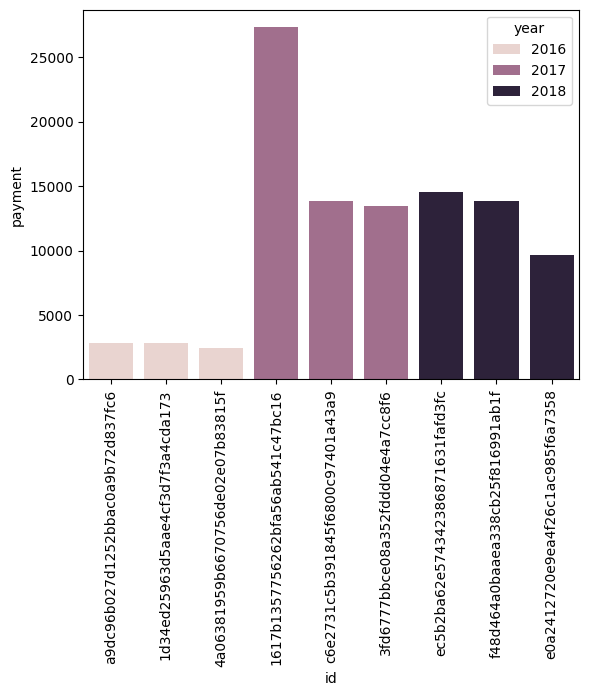

In [41]:
query = """Select year, cus, payment, a from (Select *, rank() over(partition by year order by payment desc) as a from (Select year(orders.order_purchase_timestamp) as year, orders.order_id, orders.customer_id as cus, sum(payments.payment_value) as payment from orders join payments on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp), orders.order_id, orders.customer_id) as b) as c where a<=3"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["year","id","payment","rank"])
df.head()
sns.barplot(x="id", y="payment", data=df, hue="year")
plt.xticks(rotation=90)
plt.show()